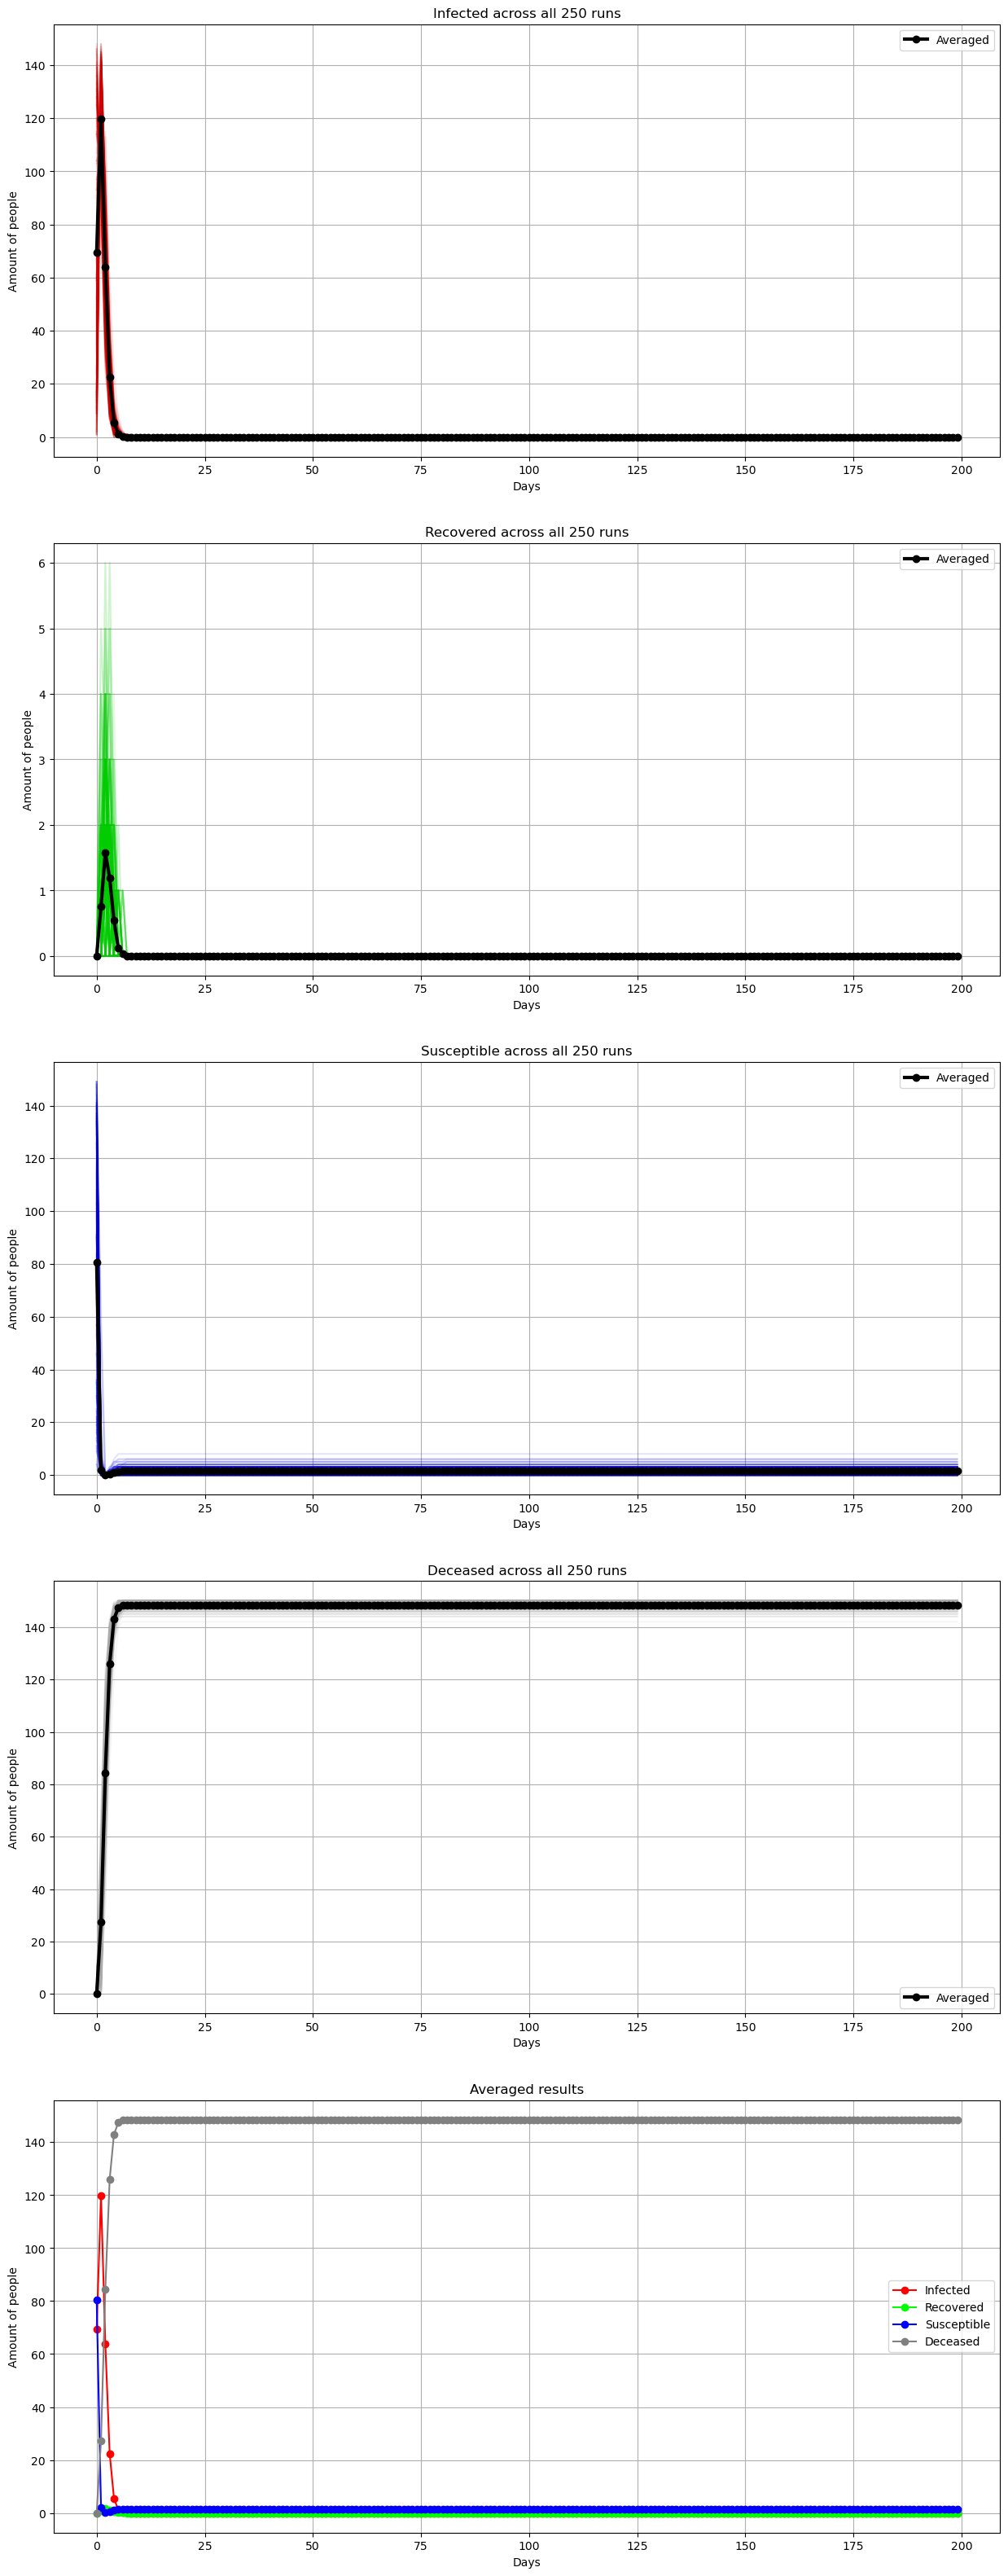

In [7]:
import matplotlib.pyplot as plt
import random
import networkx as nx
import time

plt.rcParams["figure.figsize"] = (15, 40)

Rewiring_Prob = 0.3
Nodes = 150
Nearest_Neighbors = 6
simulations_to_run = 250

simulation_time = 200
recovery_chance = 0.01
lose_recovery_chance = 0.9
infection_coefficient = 10
death_chance = 0.4

x_axis_values = [i for i in range(simulation_time)]

fig, ax = plt.subplots(5, 1)
infected_graph, recovered_graph, susceptible_graph, deceased_graph, overall_graph = ax

stats = {"Infected" : [0]*simulation_time, "Recovered" : [0]*simulation_time, "Susceptible" : [0]*simulation_time, "Deceased" : [0]*simulation_time}

def get_next_node_status(curr_status, days_passed):
    if curr_status == "Deceased":
        return "Deceased"
    elif curr_status == "Infected":
        for i in range(days_passed):
            if random.random() < recovery_chance:
                return "Recovered"
            if random.random() < death_chance:
                return "Deceased"
    elif curr_status == "Recovered":
        for i in range(days_passed):
            if random.random() < lose_recovery_chance:
                return "Susceptible"
    return curr_status

for simulation in range(simulations_to_run):
    random.seed = 250
    graph = nx.watts_strogatz_graph(Nodes, Nearest_Neighbors, Rewiring_Prob)

    #make a dictionary of the graph
    network_dict = {node: list(graph.neighbors(node)) for node in graph.nodes}

    # Assign node attributes
    patient_zero_ind = random.randint(0, Nodes-1)
    nx.set_node_attributes(graph, {1: "Infected", 2: "Susceptible", 3: "Recovered", 4: "Deceased"}, "status")
    for node in graph.nodes():
        graph.nodes[node]["status"] = "Susceptible"
        graph.nodes[node]["time_since_infected"] = -1
        graph.nodes[node]["time_since_recovered"] = -1
    graph.nodes[patient_zero_ind]['status'] = 'Infected'
    graph.nodes[patient_zero_ind]["time_since_infected"] = 0
    graph.nodes[patient_zero_ind]["time_since_recovered"] = -1


    # Extract attributes into a dictionary
    node_status_dict = nx.get_node_attributes(graph, "status")
    # Output: {1: 'Infected', 2: 'Susceptible', 3: 'Recovered'}

    # Assign random edge strengths (weights) between 0.1 and 1.0
    for u, v in graph.edges():
        graph[u][v]['weight'] = round(random.uniform(0.01, 1.0), 2)

    # Convert to a dictionary with edge strengths
    edge_strengths = {(u, v): graph[u][v]['weight'] for u, v in graph.edges()}

    random.seed = round(time.time()*1000) # set the seed to a pseudo-random value
    this_simulation_stats = {"Infected" : [0]*simulation_time, "Recovered" : [0]*simulation_time, "Susceptible" : [0]*simulation_time, "Deceased" : [0]*simulation_time}
    for t in range(simulation_time): #simulation time
        for node in graph.nodes(): #all nodes
            stats[graph.nodes[node]["status"]][t] += 1
            this_simulation_stats[graph.nodes[node]["status"]][t] += 1
            if graph.nodes[node]["status"] == 'Infected': #check infected

                for neighbor in list(graph.neighbors(node)): #infect
                    infect_chance = random.random()
                    if infection_coefficient * graph[neighbor][node]['weight'] >= infect_chance and graph.nodes[neighbor]["status"] == "Susceptible":
                        graph.nodes[neighbor]['status'] = 'Infected'
                        graph.nodes[neighbor]["time_since_infected"] = 0

                # check if should be recovered
                graph.nodes[node]["time_since_infected"] += 1
                next_status = get_next_node_status(graph.nodes[node]["status"], graph.nodes[node]["time_since_infected"])
                if next_status == "Recovered":
                    graph.nodes[node]["status"] = next_status
                    graph.nodes[node]["time_since_recovered"] = 0
                    graph.nodes[node]["time_since_infected"] = -1
                elif next_status == "Deceased":
                    graph.nodes[node]["status"] = next_status
                    graph.nodes[node]["time_since_infected"] = -1
                
            elif graph.nodes[node]["status"] == "Recovered":
                graph.nodes[node]["time_since_recovered"] += 1
                next_status = get_next_node_status(graph.nodes[node]["status"], graph.nodes[node]["time_since_recovered"])
                if next_status != graph.nodes[node]["status"]:
                    graph.nodes[node]["status"] = next_status
                    graph.nodes[node]["time_since_recovered"] = -1
    infected_graph.plot(x_axis_values, this_simulation_stats["Infected"], "-", color="#cc0000", alpha=0.1)
    recovered_graph.plot(x_axis_values, this_simulation_stats["Recovered"], "-", color="#00cc00", alpha=0.1)
    susceptible_graph.plot(x_axis_values, this_simulation_stats["Susceptible"], "-", color="#0000cc", alpha=0.1)
    deceased_graph.plot(x_axis_values, this_simulation_stats["Deceased"], "-", color="#aaaaaa", alpha=0.1)


for stat in stats.values():
    for i in range(simulation_time):
        stat[i] = stat[i]/simulations_to_run
        

overall_graph.plot(x_axis_values, stats["Infected"], "-o", label="Infected", color="red")
infected_graph.plot(x_axis_values, stats["Infected"], "-o", label="Averaged", color="black", lw=3)
overall_graph.plot(x_axis_values, stats["Recovered"], "-o", label="Recovered", color="lime")
recovered_graph.plot(x_axis_values, stats["Recovered"], "-o", label="Averaged", color="black", lw=3)
overall_graph.plot(x_axis_values, stats["Susceptible"], "-o", label="Susceptible", color="blue")
susceptible_graph.plot(x_axis_values, stats["Susceptible"], "-o", label="Averaged", color="black", lw=3)
overall_graph.plot(x_axis_values, stats["Deceased"], "-o", label="Deceased", color="grey")
deceased_graph.plot(x_axis_values, stats["Deceased"], "-o", label="Averaged", color="black", lw=3)

infected_graph.grid()
recovered_graph.grid()
susceptible_graph.grid()
deceased_graph.grid()
overall_graph.grid()

infected_graph.legend()
recovered_graph.legend()
susceptible_graph.legend()
deceased_graph.legend()
overall_graph.legend()

infected_graph.set_xlabel("Days")
recovered_graph.set_xlabel("Days")
susceptible_graph.set_xlabel("Days")
deceased_graph.set_xlabel("Days")
overall_graph.set_xlabel("Days")

infected_graph.set_ylabel("Amount of people")
recovered_graph.set_ylabel("Amount of people")
susceptible_graph.set_ylabel("Amount of people")
deceased_graph.set_ylabel("Amount of people")
overall_graph.set_ylabel("Amount of people")

infected_graph.set_title(f"Infected across all {simulations_to_run} runs")
recovered_graph.set_title(f"Recovered across all {simulations_to_run} runs")
susceptible_graph.set_title(f"Susceptible across all {simulations_to_run} runs")
deceased_graph.set_title(f"Deceased across all {simulations_to_run} runs")
overall_graph.set_title("Averaged results")
plt.show()